In [1]:
import keras
from keras.models import Sequential
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.layers import Dense, Input, Flatten, Reshape, Concatenate, Dropout, Embedding, LeakyReLU, Embedding
from keras import Model
import numpy as np
import pandas as pd
from keras import backend as K

In [2]:
def relu_1(x):
    return K.relu(x, max_value=1)

In [3]:
def define_discriminator(in_shape=(14381,), n_classes = 2):
  # label input
  in_label = Input(shape=(1,))
  # embedding for categorical input
  li = Embedding(n_classes, 50)(in_label)
  lab_rep = Dense(in_shape[0], activation="relu")(li)
  lab_rep = Reshape(in_shape)(lab_rep)
  # data input
  in_data = Input(shape=in_shape)
  # concat label as a channel
  merge = Concatenate()([in_data, lab_rep])
	# downsample
  hidden1 = Dense(1000, activation='relu')(merge)
  hidden2 = Dense(512, activation='relu')(hidden1)
  hidden3 = Dense(256, activation='relu')(hidden2)
  # dropout
  fe = Dropout(0.4)(hidden3)
  # output
  out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
  model = Model([in_data, in_label], out_layer)
	# compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [4]:
def define_generator(latent_dim, n_classes = 2, in_shape = (14381,)):
  # label input
  in_label = Input(shape=(1,))
	# embedding for categorical input
  li = Embedding(n_classes, 50)(in_label)
  # scale up to image dimensions with linear activation
  lab_h1 = Dense(100, activation="relu")(li)
  lab_rep = Dense(in_shape[0], activation="relu")(lab_h1)
  lab_rep = Reshape(in_shape)(lab_rep)
  
  # image generator input
  in_lat = Input(shape=(latent_dim,))
  gen = Dense(in_shape[0], activation="relu")(in_lat)
  # merge image gen and label input
  merge = Concatenate()([gen, lab_rep])
  hidden1 = Dense(5000, activation="relu")(merge)
  dp1 = Dropout(0.4)(hidden1)
  
  hidden2 = Dense(5000, activation='relu')(dp1)
  dp2 = Dropout(0.4)(hidden2)

  hidden3 = Dense(5000, activation='relu')(dp2)
  dp3 = Dropout(0.4)(hidden3)
  
  hidden4 = Dense(5000, activation='relu')(dp3)
  fe = Dropout(0.4)(hidden4)

  # output
  out_layer = Dense(in_shape[0], activation=relu_1)(fe)
  # define model
  model = Model([in_lat, in_label], out_layer)
  return model

In [ ]:
latent_dim = 100
g_model = define_generator(latent_dim)
g_model.output

<tf.Tensor 'dense_7/clip_by_value:0' shape=(None, 14381) dtype=float32>

In [5]:
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable
  d_model.trainable = False
  # get noise and label inputs from generator model
  gen_noise, gen_label = g_model.input
  # get image output from the generator model
  gen_output = g_model.output
  # connect image output and label input from generator as inputs to discriminator
  gan_output = d_model([gen_output, gen_label])
  # define gan model as taking noise and label and outputting a classification
  model = Model([gen_noise, gen_label], gan_output)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [7]:
# select real samples
def generate_real_samples(train_data, y_train, n_samples):
	# choose random instances
  ix = randint(0, train_data.shape[0], n_samples)
  # select images and labels
  X, labels = train_data[ix],y_train[ix]
  # generate class labels
  y = ones((n_samples, 1))
  return [X, labels], y

In [8]:
def generate_latent_points(latent_dim, n_samples, n_classes=2):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

In [9]:
def train(g_model, d_model, gan_model, train_data, y_train, latent_dim, n_epochs=200, n_batch=64):
	bat_per_epo = int(train_data.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(train_data, y_train, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('cgan_generator.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data = pd.read_csv(r"/content/drive/My Drive/train_features.csv")
train_data = train_data.to_numpy()
print(train_data.shape)
file = open("/content/drive/My Drive/train_labels.txt", 'r')
y_train = file.readlines()
y_train  = np.array(y_train)
y_train = y_train.astype('float32')
print(type(y_train[0]))
print(y_train.shape)

(444, 14381)
<class 'numpy.float32'>
(444,)


In [10]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# train model

#train(g_model, d_model, gan_model,train_data, y_train, latent_dim)

NameError: ignored

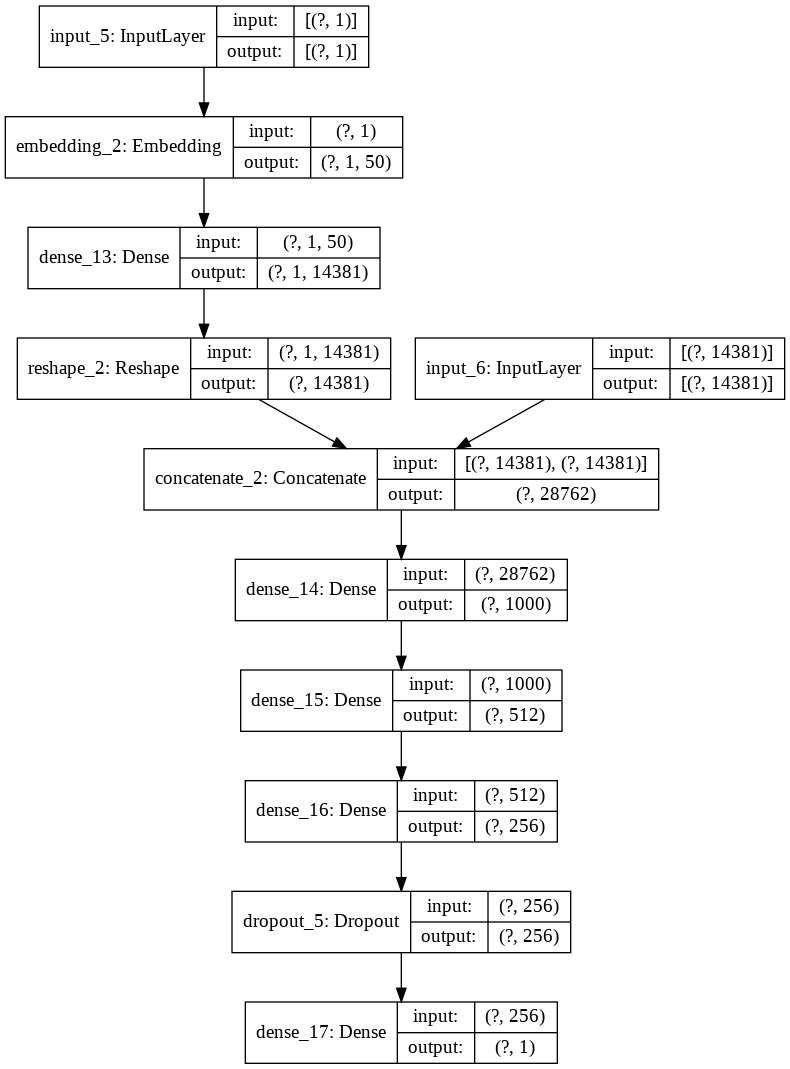

In [14]:
from keras.utils.vis_utils import plot_model
plot_model(d_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

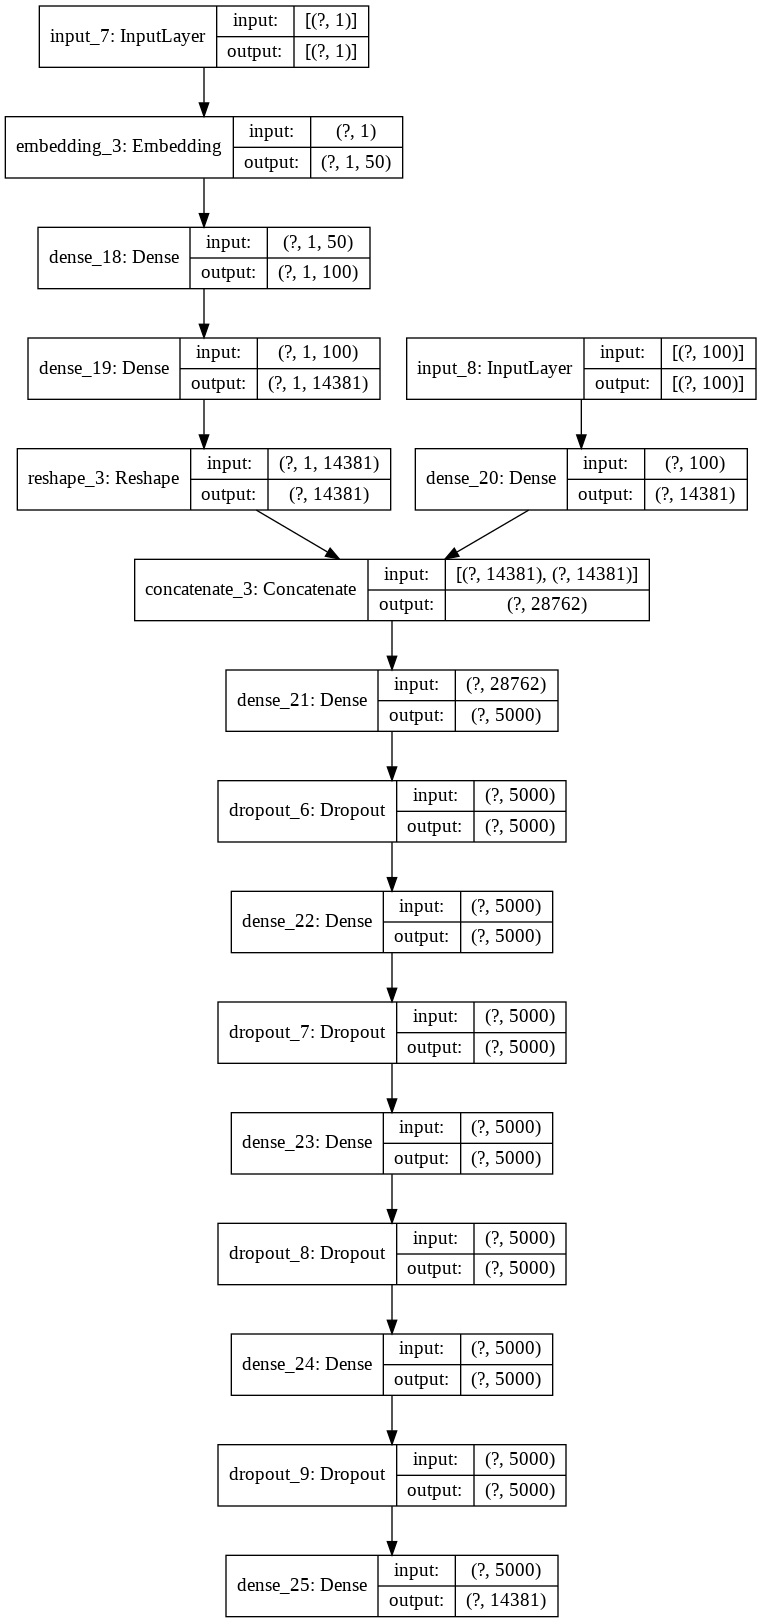

In [15]:
plot_model(g_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
g_model.save('/content/drive/My Drive/cgan_generator.h5')

In [ ]:
drive.flush_and_unmount()